In [54]:
import matplotlib.pyplot as plt 
import pandas as pd
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import psycopg2
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

from keras_functions import *

In [6]:
con = psycopg2.connect(database='codeforces', user='Joy')
cur = con.cursor()

In [3]:
binvars = get_categorical_variables([
    'all_participanttypes',
    'all_tags',
    'all_language'
])

# Split users

Want to make sure we have a variety of different types of users
* those who gain rating quickly and those who don't
* those who start low and those who don't

In [95]:
q = """
SELECT *
FROM
    (
    SELECT *,
           max(ratingupdatetimeseconds) over (partition by handle) maxtime
    FROM user_rating
    )a
WHERE
    ratingupdatetimeseconds = maxtime
"""
last_contests = pd.read_sql(q, con)

In [140]:
q = """
SELECT handle, count(ratingupdatetimeseconds) 
FROM user_rating
GROUP BY handle
"""
contest_counts = pd.read_sql(q, con)
contest_counts.set_index('handle', inplace=True)

In [39]:
q = """
SELECT *
FROM
    (
    SELECT *,
           min(ratingupdatetimeseconds) over (partition by handle) mintime
    FROM user_rating
    )a
WHERE
    ratingupdatetimeseconds = mintime
"""
first_contests = pd.read_sql(q, con)

In [136]:
last_contests.set_index('handle', inplace=True)
first_contests.set_index('handle', inplace=True)

KeyError: 'handle'

In [145]:
first_last_contests = last_contests.join(first_contests, lsuffix="last", rsuffix="first")
first_last_contests = first_last_contests.join(contest_counts)

first_last_contests.head()

,contestidlast,contestnamelast,newratinglast,oldratinglast,ranklast,ratingupdatetimesecondslast,maxtime,contestidfirst,contestnamefirst,newratingfirst,oldratingfirst,rankfirst,ratingupdatetimesecondsfirst,mintime,count
handle,,,,,,,,,,,,,,,
-----,294,Codeforces Round #178 (Div. 2),1490,1293,286,1365355800,1365355800,49,Codeforces Beta Round #46 (Div. 2),1370,1500,344,1292608800,1292608800,10
----ensist----,221,Codeforces Round #136 (Div. 2),1368,1375,719,1346434200,1346434200,218,Codeforces Round #134 (Div. 2),1458,1500,582,1345280700,1345280700,3
---Grigor---,741,Codeforces Round #383 (Div. 1),2068,2151,436,1481042100,1481042100,5,Codeforces Beta Round #5,1492,1500,152,1269108000,1269108000,96
---JamesBond---,787,Codeforces Round #406 (Div. 2),1354,1466,2731,1490288700,1490288700,764,Codeforces Round #395 (Div. 2),1469,1500,2007,1486049700,1486049700,9
--1,812,Codeforces Round #417 (Div. 2),1522,1539,1441,1496333700,1496333700,611,Good Bye 2015,1398,1500,4455,1451498700,1451498700,9


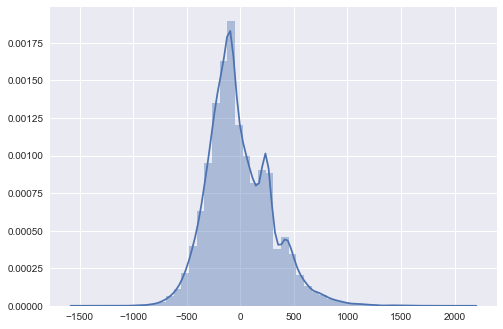

In [58]:
changes = first_last_contests.newratinglast - first_last_contests.oldratingfirst
sns.distplot(changes)

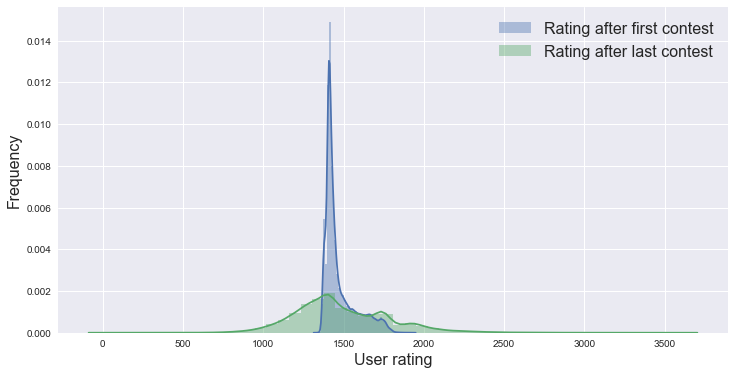

In [67]:
plt.rcParams['figure.figsize'] = [12, 6]
sns.distplot(first_last_contests.newratingfirst)
sns.distplot(first_last_contests.newratinglast)
plt.legend(['Rating after first contest', 'Rating after last contest'], fontsize=16)
plt.xlabel('User rating', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [83]:
X = first_last_contests[['newratingfirst', 'newratinglast']]
X.is_copy = False
X['change'] = X['newratinglast'] - X['newratingfirst']

In [85]:
X = X.values

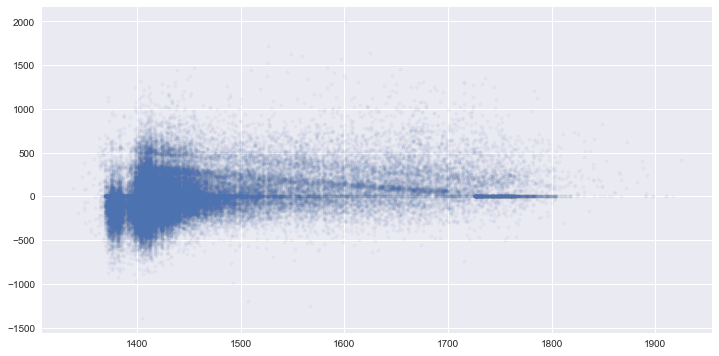

In [101]:
#sns.jointplot(X[:,0], X[:,2],
#              kind='hex',
#             ).set_axis_labels('First rating', 'Last rating')
plt.scatter(X[:,0], X[:,2], s=10, alpha=.05)

In [108]:
from sklearn.model_selection import train_test_split

In [210]:
binfirst = pd.qcut(first_last_contests.newratingfirst, 10)
binlast = pd.qcut(first_last_contests.newratinglast, 10)
train_set, test_set = train_test_split(first_last_contests, train_size=.8, stratify=zip(binfirst, binlast))

In [211]:
# split off validation set
binfirst = pd.qcut(train_set.newratingfirst, 10)
binlast = pd.qcut(train_set.newratinglast, 10)
train_set, val_set = train_test_split(train_set, train_size=.8, stratify=zip(binfirst, binlast))

In [212]:
print train_set.shape
print test_set.shape
print val_set.shape

(37679, 15)
(11775, 15)
(9420, 15)


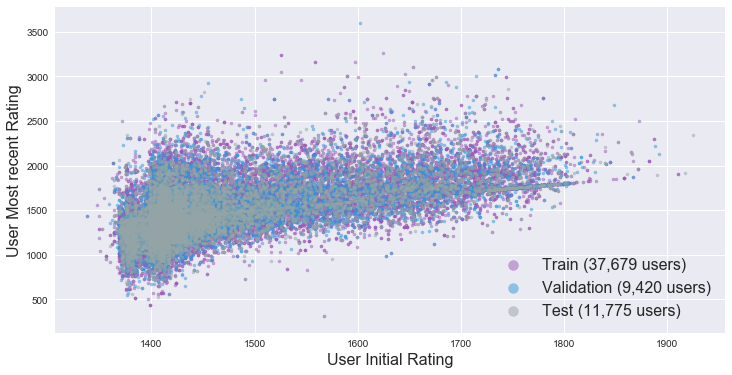

In [219]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui)
plt.scatter(train_set.newratingfirst, train_set.newratinglast, s=10, alpha=.5, c=colors[0])
plt.scatter(test_set.newratingfirst, test_set.newratinglast, s=10, alpha=.5, c=colors[1])
plt.scatter(val_set.newratingfirst, val_set.newratinglast, s=10, alpha=.5, c=colors[2])
plt.xlabel('User Initial Rating', fontsize=16)
plt.ylabel('User Most recent Rating', fontsize=16)
lgnd = plt.legend(['Train (37,679 users)', 'Validation (9,420 users)', 'Test (11,775 users)'], fontsize=16)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]

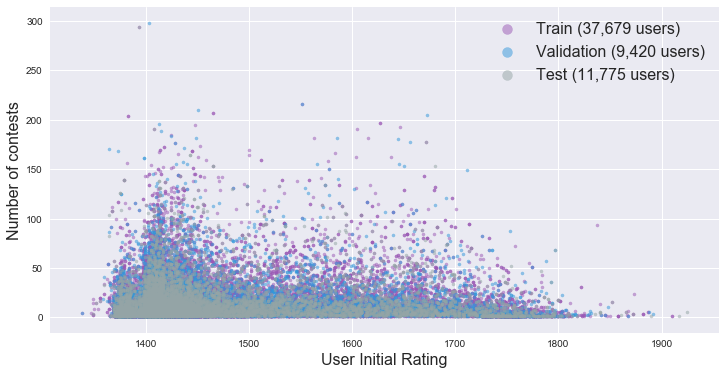

In [225]:
plt.scatter(train_set.newratingfirst, train_set['count'], s=10, alpha=.5, c=colors[0])
plt.scatter(test_set.newratingfirst, test_set['count'], s=10, alpha=.5, c=colors[1])
plt.scatter(val_set.newratingfirst, val_set['count'], s=10, alpha=.5, c=colors[2])
plt.xlabel('User Initial Rating', fontsize=16)
plt.ylabel('Number of contests', fontsize=16)
lgnd = plt.legend(['Train (37,679 users)', 'Validation (9,420 users)', 'Test (11,775 users)'], fontsize=16)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]




In [237]:
def save_handles(df, outname):
    with open(outname, 'w') as f:
        outstr = '\n'.join(df.index.values)
        f.write(outstr)

save_handles(train_set, 'set_train.txt')
save_handles(test_set, 'set_test.txt')
save_handles(val_set, 'set_val.txt')

In [4]:
get_user_data('yj12', binvars=binvars, month=3, maxtimepts=500)

(array([[[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         ..., 
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],
 
        [[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         ..., 
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  1. , ...,  0. ,  0. ,  0. ]],
 
        [[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         ..., 
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],
 
        ..